# HW2 - Stock Picking

This stock picking algorithm is designed to create an investment portfolio that optimizes for long-term (>10 years) gains. The basis for the design is on three principles:
1. Non-volatile stocks generally follow the shape of the S&P 500
2. Over time the market trends upwards with cycles of recessions
3. Companies with large market caps are better bets in the long run

## Non-Volatile Stock Trends

First, let's analyze the claim that stocks follow the S&P 500. This claim stems from the idea that the S&P 500 is an index fund and thus presents a picture of the stock market as a whole. This means that every company in the stock market is generally affected by market trends. We can see that by comparing the stocks of common blue-chip companies with the S&P 500. 

In [43]:
import pandas as pd
import yfinance as yf
import numpy as np
from yahoofinancials import YahooFinancials
import yahooquery as yq
import matplotlib
from matplotlib import pyplot as plt

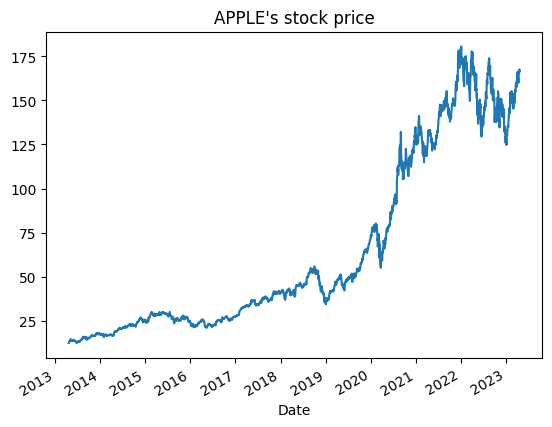

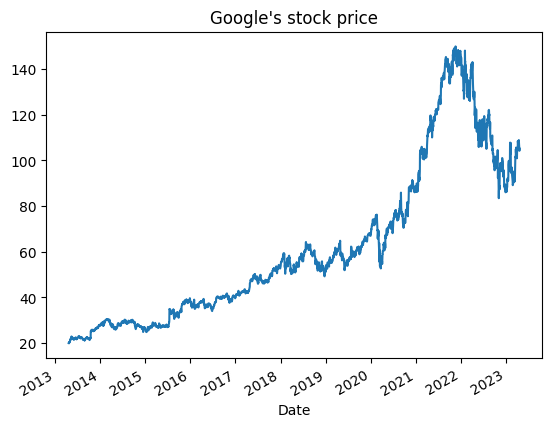

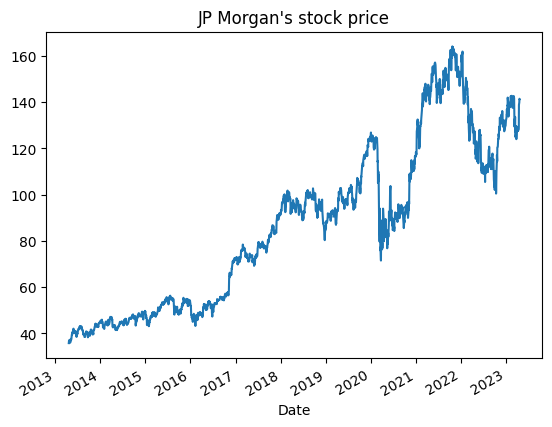

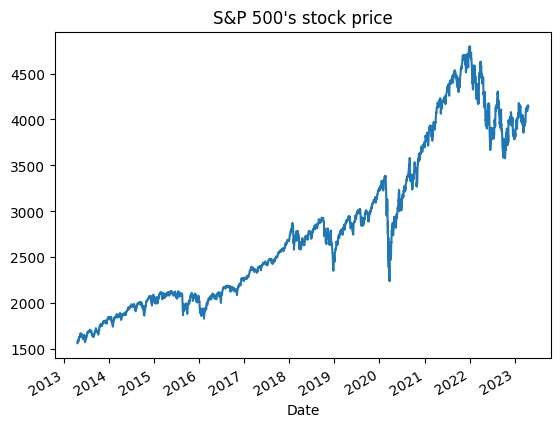

In [2]:
# Apple
aapl_ticker = yf.Ticker('AAPL')
aapl_df = aapl_ticker.history(period="10y")
aapl_df['Close'].plot(title="APPLE's stock price")
plt.show()

# Google
googl_ticker = yf.Ticker('GOOGL')
googl_df = googl_ticker.history(period="10y")
googl_df['Close'].plot(title="Google's stock price")
plt.show()

# JP Morgan
jpm_ticker = yf.Ticker('JPM')
jpm_df = jpm_ticker.history(period="10y")
jpm_df['Close'].plot(title="JP Morgan's stock price")
plt.show()

# S&P 500
gspc_ticker = yf.Ticker('^GSPC')
gspc_df = gspc_ticker.history(period="10y")
gspc_df['Close'].plot(title="S&P 500's stock price")
plt.show()

As can be seen from the plots above, these blue-chip stocks generally follow the trend of the S&P 500. This means that these companies are havily influenced by the trends of the general market. If we can isolate the performance of these stocks from the trends of the whole market, we can see if they generally outperform or underperform the market. To do this, we will first try a naive approach where we will scale all the plots and compare them at the same scale.

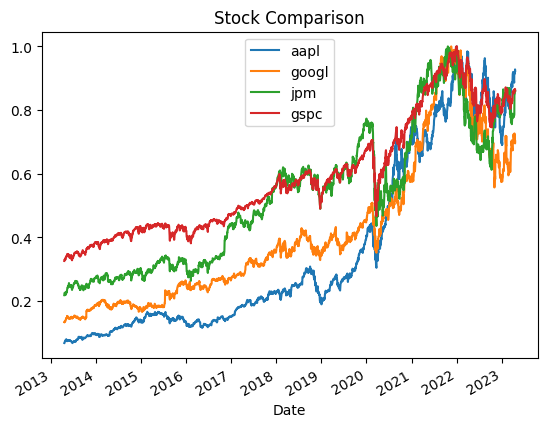

In [3]:
# Scale Stock Arrays
aapl = aapl_df['Close'] / aapl_df['Close'].max()
googl = googl_df['Close'] / googl_df['Close'].max()
jpm = jpm_df['Close'] / jpm_df['Close'].max()
gspc = gspc_df['Close'] / gspc_df['Close'].max()


aapl.plot(label='aapl')
googl.plot(label='googl')
jpm.plot(label='jpm')
gspc.plot(label='gspc')

plt.legend(loc='upper center')
plt.title("Stock Comparison")

plt.show()

However, this naive approach will not work. Scaling the stocks this way, we can see that the S&P 500 outperforms almost all of these blue-chip stocks and yet none of these stocks are inherently bad bets to make. Since we are trying to create a long-term investment portfolio, we care much more about the "shape" of the stock or more technically the volatility of the stock. A good indicator of the volatility of a stock is the "beta" metric. 

In [4]:
print("Apple: ", aapl_ticker.info['beta'])
print("Google: ", googl_ticker.info['beta'])
print("JP Morgan: ", jpm_ticker.info['beta'])

Apple:  1.296885
Google:  1.099653
JP Morgan:  1.080968


The S&P 500 has a beta of 1. Having a beta > 1 means that the stock is more volatile than the market and having a beta < 1 means that stock is less volatile. As seen above, both Google and JP Morgan have almost the same volatility as the market. Apple has a slightly higher volatility.

## S&P 500 Trends

Now, let's analyze the claim that the market generally trends upwards with cycles of volatility. To do this, let's look at the S&P 500 for the last 30 years.

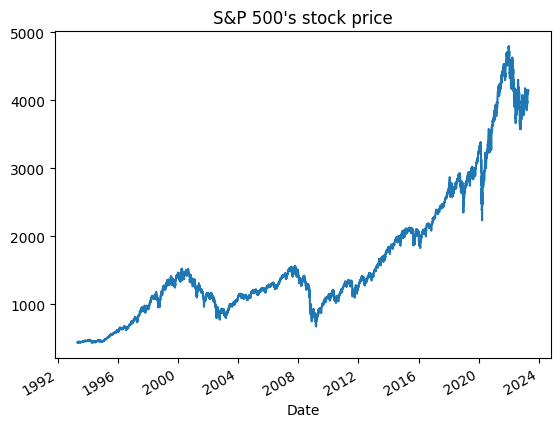

In [5]:
# S&P 500
gspc_ticker = yf.Ticker('^GSPC')
gspc_df = gspc_ticker.history(period="30y")
gspc_df['Close'].plot(title="S&P 500's stock price")
plt.show()

The plot above clearly shows us that the market has grown immensely since 1992. We can also clearly see that there is a cyclical pattern of recessions at a larger time scale. We can clearly notice the 2008 housing market crash and the recent 2020 crash due to the pandemic. Since we are optimizing for long-term investment, we care more about these large scale crashes rather than the every day ups and downs the market goes through. In order to identify these longer time scale trends and take advantage of them, we need to filter out the noise. To do this, we can use a moving average filter.

In [6]:
def moving_average(data, window):
    return np.convolve(data, np.ones(window), 'valid') / window

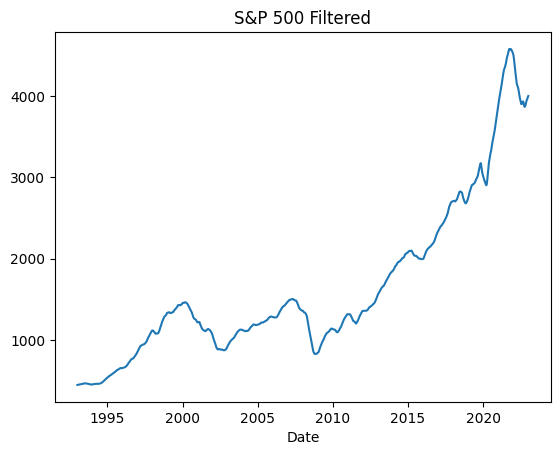

In [7]:
# Filtered S&P 500
gspc_filtered = moving_average(gspc_df['Close'], 100)
dates = np.linspace(1993, 2023, gspc_filtered.size)
plt.plot(dates, gspc_filtered)
plt.title("S&P 500 Filtered")
plt.xlabel("Date")
plt.show()

Now, thanks to our moving average filter we are able to better identify the market trends at larger time scales. Our algorithm needs to identify these market shifts in order to buy low and sell high. This means our algorithm needs to identify the maxima and minima of the graph. At its most optimal behavior, the algorithm will buy when the graph is at a minima and sell when it is at a maxima. Of course, there is no way to predict when the market will reach a maxima or minima. So, instead our algorithm will base its decisions on the "rate of change" of the market. To identify the rate of change of the market, we can take the derivative of the data.

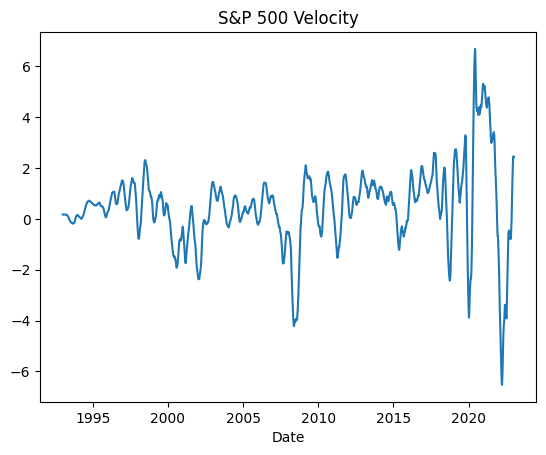

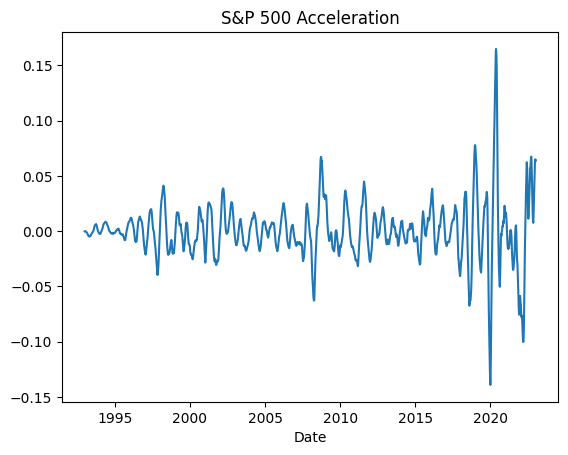

In [8]:
gspc_velocity = np.gradient(gspc_filtered)
gspc_filtered_velocity = moving_average(gspc_velocity, 50)
dates = np.linspace(1993, 2023, gspc_filtered_velocity.size)
plt.plot(dates, gspc_filtered_velocity)
plt.title("S&P 500 Velocity")
plt.xlabel("Date")
plt.show()

gspc_acceleration = np.gradient(gspc_filtered_velocity)
gspc_filtered_acceleration = moving_average(gspc_acceleration, 50)
dates = np.linspace(1993, 2023, gspc_filtered_acceleration.size)
plt.plot(dates, gspc_filtered_acceleration)
plt.title("S&P 500 Acceleration")
plt.xlabel("Date")
plt.show()

By taking the derivative, we can find the "velocity" and "acceleration" of the market. When the velocity is high, it means that the price of the stock is rapidly increasing and when it is low, it means that the price is rapidly decreasing. We want to be buying stock when the market is at its lowest and selling when it is at its highest. This is where knowing the "acceleration" of the market comes into play. We know that the market is about to reach a maxima or a minima when the market is decelerating. If the market is at a maxima and it is higher than any previous point in history, then we want to sell. If the market is at a minima and it is lower than the global maxima, then we want to buy. Otherwise, we want to hold onto the stock.

## Small Market Cap Trends

Companies with small market caps are not ideal for long time scale investments. Firstly, they have a lot more volatility making them susceptible to market shocks. We can see this when comparing stocks like Hubspot and Twilio to the S&P and looking at their beta metrics.

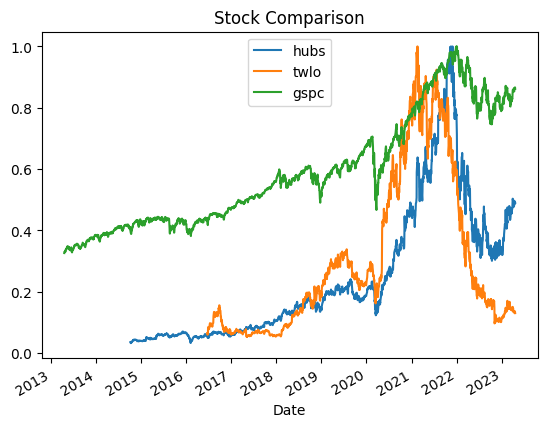

Hubspot Beta:  1.61211
Twilio Beta:  1.466089


In [9]:
# Hubspot
hubs_ticker = yf.Ticker('HUBS')
hubs_df = hubs_ticker.history(period="10y")
hubs = hubs_df['Close'] / hubs_df['Close'].max()

# Twilio
twlo_ticker = yf.Ticker('TWLO')
twlo_df = twlo_ticker.history(period="10y")
twlo = twlo_df['Close'] / twlo_df['Close'].max()

# S&P 500
gspc_ticker = yf.Ticker('^GSPC')
gspc_df = gspc_ticker.history(period="10y")
gspc = gspc_df['Close'] / gspc_df['Close'].max()

hubs.plot(label='hubs')
twlo.plot(label='twlo')
gspc.plot(label='gspc')

plt.legend(loc='upper center')
plt.title("Stock Comparison")

plt.show()

print("Hubspot Beta: ", hubs_ticker.info['beta'])
print("Twilio Beta: ", twlo_ticker.info['beta'])

They both have much higher beta values and are qualitativly more volatile. The other problem with these companies for long-term investment is that we don't know if these companies will survive for a long time. Twilio for instance has not even been on the market for 10 years. It will take time for us to konw if these companies will mature into a safe bet. We may, however, be able to use these companies in a higher-risk growth focused portfolio. 

## Investment Strategy

Now that the basic principles of the investment strategy have been outlined, we can discuss the specific tactics used to generate three different kinds of portfolios: income, growth, and ESG (environmental, social, governance).

All three portfolios, however, will use the same basic investment strategy. Attempt to buy stock during a recession and sell stock during a boom. 

In [10]:
def base_invest(ticker):
    # Get ticker's stock data
    ticker_df = ticker.history(period="20y")
    
    # Filter Data
    order = (int)(ticker_df['Close'].max() - ticker_df['Close'].min())
    ticker_filtered = moving_average(ticker_df['Close'], order)
    
    # Calclate stock velocity
    ticker_velocity = np.gradient(ticker_filtered)
    ticker_velocity_filtered = moving_average(ticker_velocity, order)
    
    # Calculate stock acceleration
    ticker_acceleration = np.gradient(ticker_velocity_filtered)
    ticker_acceleration_filtered = moving_average(ticker_acceleration, order)
    
    # Plot Stock Data
    ticker_dates = np.linspace(2003, 2023, ticker_filtered.size)
    plt.plot(ticker_dates, ticker_filtered)
    plt.show()
    
    velocity_dates = np.linspace(2003, 2023, ticker_velocity_filtered.size)
    plt.plot(velocity_dates, ticker_velocity_filtered)
    plt.show()
    
    acceleration_dates = np.linspace(2003, 2023, ticker_acceleration_filtered.size)
    plt.plot(acceleration_dates, ticker_acceleration_filtered)
    plt.show()
    
    # Find standard deviation of velocity and acceleration
    velocity_std = np.std(ticker_velocity_filtered)
    acceleration_std = np.std(ticker_acceleration_filtered)
    
    # Print stock metrics
    print("Acceleration std: ", acceleration_std)
    print("Acceleration: ", ticker_acceleration_filtered[-1])
    print("Max Price: ", ticker_filtered.max())
    print("Stock Price: ", ticker_filtered[-1])
    
    # If stock is at maxima, sell. If stock is at minima, buy. Otherwise, hold.
    if (ticker_acceleration_filtered[-1] < -acceleration_std and ticker_filtered[-1] > ticker_filtered.max()):
        return "sell"
    elif (ticker_acceleration_filtered[-1] < -acceleration_std and ticker_filtered[-1] < ticker_filtered.min()):
        return "buy"
    else:
        return "hold"

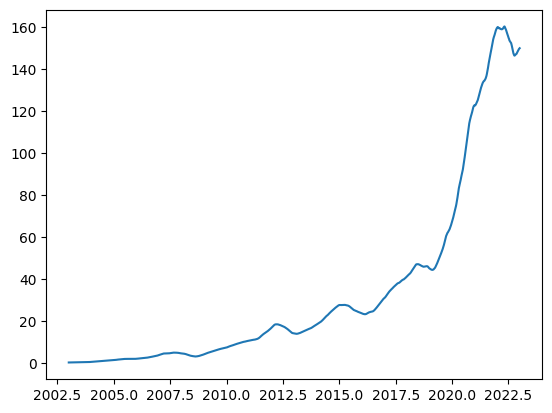

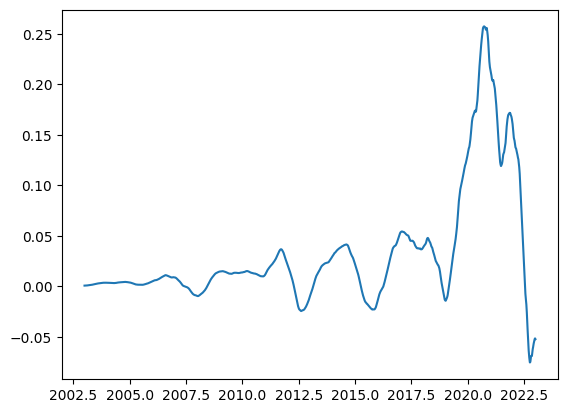

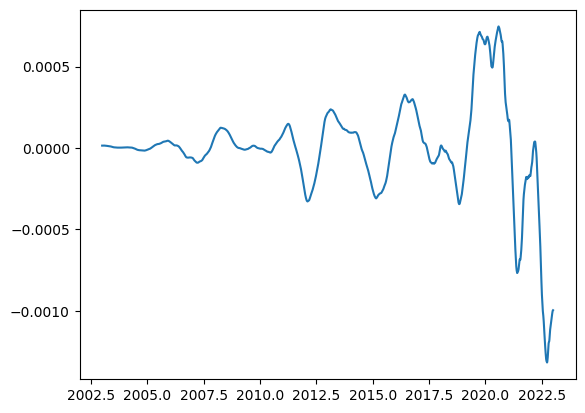

Acceleration std:  0.0002988311005213992
Acceleration:  -0.000996113870369554
Max Price:  160.19369413587782
Stock Price:  149.85764918857151
The algorithm says  hold


In [11]:
print("The algorithm says ", base_invest(yf.Ticker('AAPL')))

### Income Portfolio

For an income portfolio, we will focus on a long-term investment strategy. This means we will prioritise companies that have low volatility and large market caps.

In [12]:
def income_invest(ticker):
    # Get market cap from Yahoo Financials
    yh_ticker = YahooFinancials(ticker.ticker)
    market_cap = yh_ticker.get_market_cap()
    
    # Print Market Cap and Beta
    print("Market Cap: ", market_cap)
    print("Beta: ", ticker.info['beta'])
    
    # Weed out companies with high volatility and low market cap
    if (ticker.info['beta'] > 1.4 or market_cap < 50000000000):
        return "sell"
    
    return base_invest(ticker)

In [13]:
income_invest(yf.Ticker('HUBS'))

Market Cap:  20590620672
Beta:  1.61211


'sell'

Market Cap:  75023982592
Beta:  1.143281


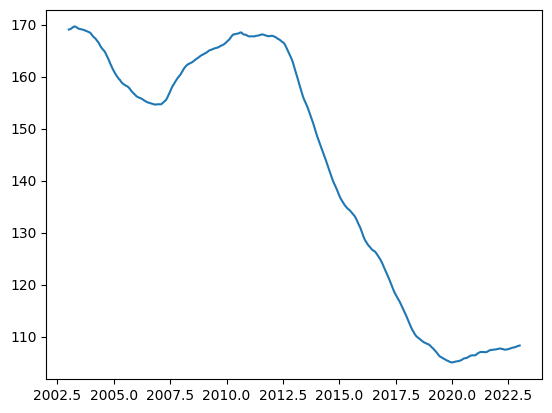

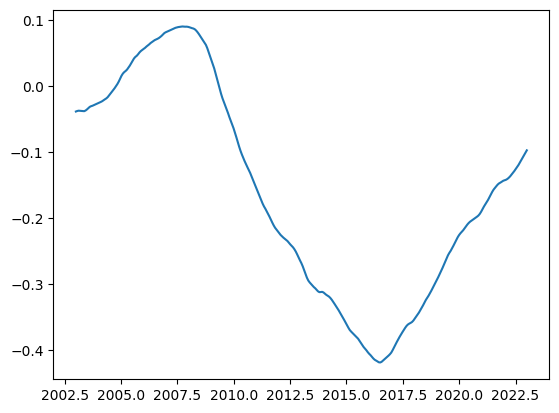

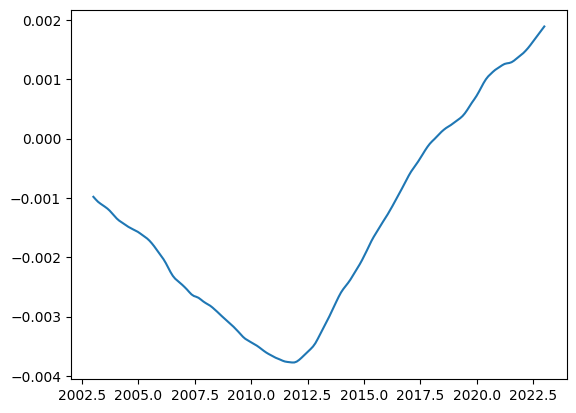

Acceleration std:  0.0016814143902629847
Acceleration:  0.0018902756887727082
Max Price:  169.62514939948693
Stock Price:  108.28533582545039


'hold'

In [14]:
income_invest(yf.Ticker('ABNB'))

### Growth Portfolio

For a growth portfolio, we will focus on a high growth investment strategy. This means we will prioritise companies that may have higher volatility but a large amount of growth.

In [15]:
def growth_invest(ticker):   
    # Print Market Cap and Beta
    print("Revenue Growth: ", ticker.info['revenueGrowth'])
    
    #Weed out companies with low growth
    if (ticker.info['revenueGrowth'] < 0):
        return "sell"
    
    return base_invest(ticker)

In [16]:
growth_invest(yf.Ticker('AAPL'))

Revenue Growth:  -0.055


'sell'

Revenue Growth:  0.241


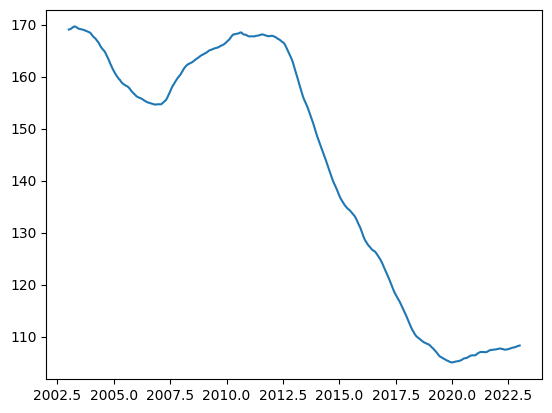

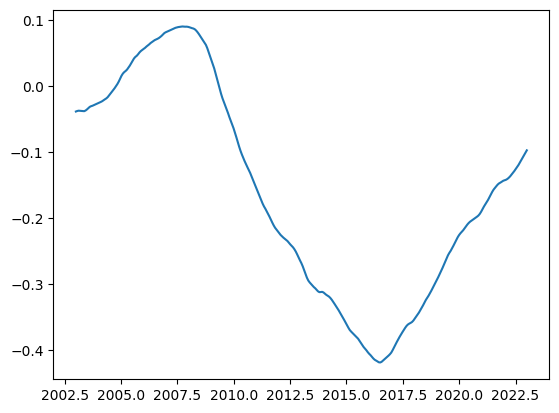

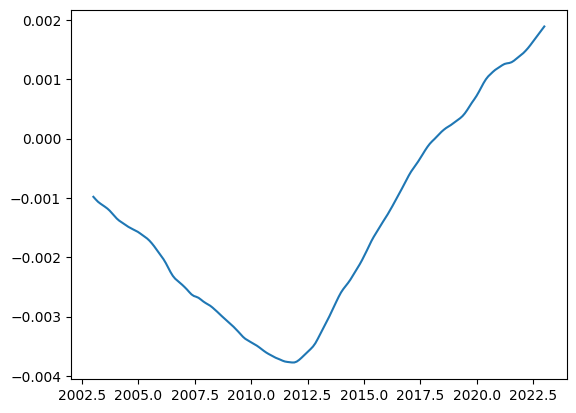

Acceleration std:  0.0016814143902629847
Acceleration:  0.0018902756887727082
Max Price:  169.62514939948693
Stock Price:  108.28533582545039


'hold'

In [17]:
growth_invest(yf.Ticker('ABNB'))

### ESG Portfolio

For a ESG portfolio, we will focus on an investment strategy that will provide returns while also investing in companies that do social good. 

In [49]:
def esg_invest(ticker):
    # Attempt to retrieve ESG Data
    try: 
        print("ESG: ", ticker.sustainability['totalEsg'])
        
        # Weed out companies with low ESG
        if (ticker.sustainability['totalEsg'] < 50):
            return "sell"
    except:
        print("Unable to get ESG due to decryption error")
        
    
    return base_invest(ticker)

Unable to get ESG due to decryption error


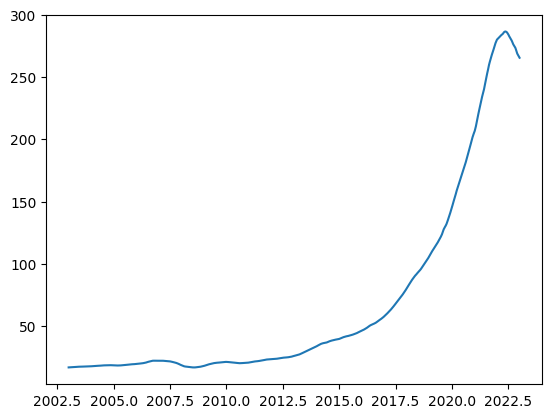

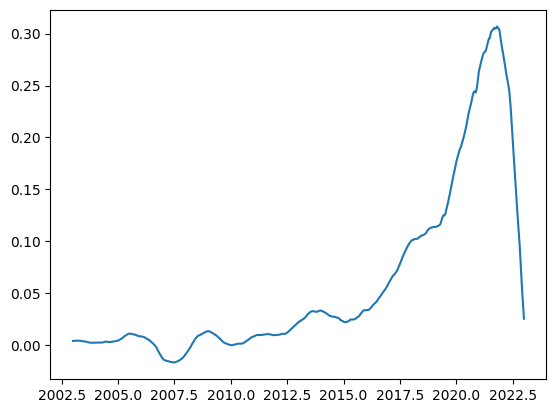

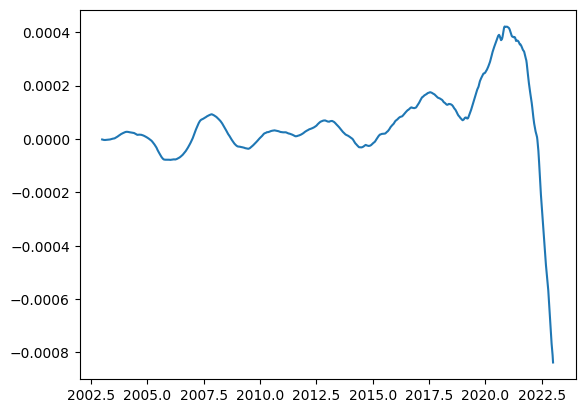

Acceleration std:  0.00015113519573609595
Acceleration:  -0.0008376166519314909
Max Price:  286.70830071592184
Stock Price:  265.5911266081924


'hold'

In [50]:
esg_invest(yf.Ticker('MSFT'))

## Final Procedure

In [51]:
def invest(ticker, client=False):
    if (client == "income"):
        return income_invest(ticker)
    elif (client == "growth"):
        return growth_invest(ticker)
    elif (client == "esg"):
        return esg_invest(ticker)
    else:
        return base_invest(ticker)